In [12]:
cd ../src

/Users/dani/Google Drive/Uni/Master/P4 2021/DD2424 - Deep Learning for Data Science/Project/ScarceClassifier/src


In [13]:
from d07_visualization.viz_training import plot_acc, plot_training_loss, plot_losses
from d04_mixmatch.wideresnet import WideResNet
from d02_data.load_data import get_dataloaders_ssl
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [196]:
model_name = '250_lbl_81_acc.pt'
saved_model = torch.load(f'../models/saved_models/{model_name}', map_location=torch.device('cpu')) 

model = WideResNet(depth=28, k=2, n_out=10, bias=False)
model.load_state_dict(saved_model['model_state_dict'])

# optim = ...
# optim.load_state_dict(saved_model['optimizer_state_dict'])

loss_train = saved_model['loss_train']
loss_val = saved_model['loss_val']
acc_train = saved_model['acc_train']
acc_val = saved_model['acc_val']


In [197]:
loss_batch = saved_model['loss_batch']
lx = saved_model['lx']
lu = saved_model['lu']
lu_weighted = saved_model['lu_weighted']

In [198]:
saved_model.keys()

dict_keys(['step', 'model_state_dict', 'ema_state_dict', 'optimizer_state_dict', 'loss_train', 'loss_val', 'acc_train', 'acc_val', 'loss_batch', 'lx', 'lu', 'lu_weighted', 'steps', 'batch_size', 'num_labels', 'lambda_u_max', 'step_top_up', 'lr', 'weight_decay', 'momentum', 'lr_decay', 'lbl_idx', 'unlbl_idx', 'val_idx'])

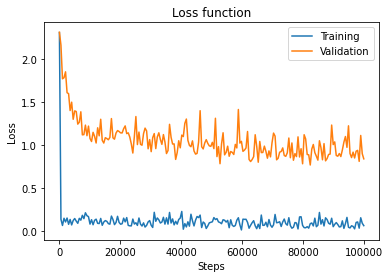

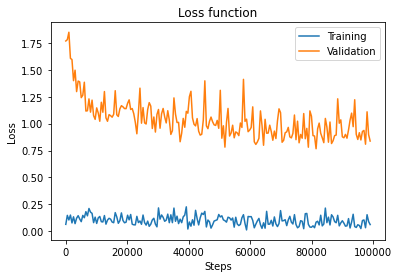

In [199]:
plot_training_loss(loss_train, loss_val, step=500)
plt.show()
plot_training_loss(loss_train[2:], loss_val[2:], step=500)


Max val acc: 80.96


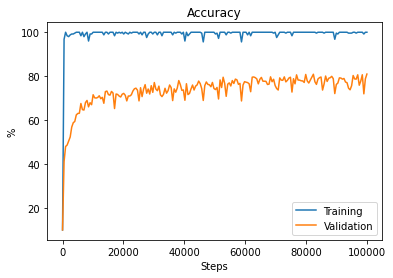

In [200]:
print('Max val acc: ' + str(max(acc_val)))
plot_acc(acc_train, acc_val, step=500)


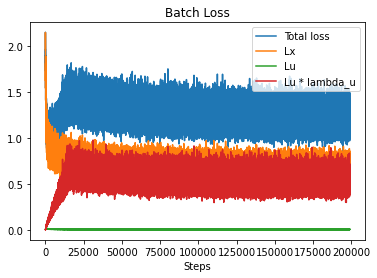

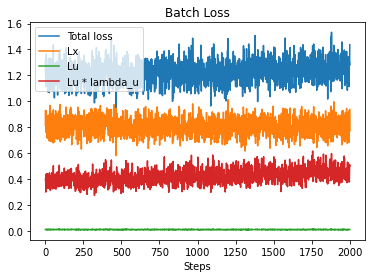

In [201]:
plot_losses(loss_batch[50:], lx[50:], lu[50:], lu_weighted[50:])
plt.show()
idx1 = 9000
idx2 = 11000
plot_losses(loss_batch[idx1:idx2], lx[idx1:idx2], lu[idx1:idx2], lu_weighted[idx1:idx2])

In [202]:
id = np.argmax(lx[9500:10000])
print(id)
print(np.round(lx[9780:9790],2))


467
[0.9  0.75 0.76 0.91 0.82 0.78 0.69 0.8  0.73 0.82]


In [203]:
def evaluate(dataloader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    correct, total, loss = 0, 0, 0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total * 100
    return loss, acc

_, _, _, test_loader = get_dataloaders_ssl(path='../data', batch_size=64, num_labeled=250)
test_val, test_acc = evaluate(test_loader)
print("Test accuracy: %.3f" % (test_acc))

Files already downloaded and verified
Files already downloaded and verified
Test accuracy: 79.700


In [11]:
loss_list = []
for i in range(10):
    loss_list.append(round(np.mean(lu[i*1000:(i+1)*1000]),3))
print(loss_list)

[0.01, 0.013, 0.011, 0.008, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004]


## Progressive Hard Labelling

In [ ]:
_, unlbl_loader, _, _ = get_dataloaders_ssl(path='../data', batch_size=64, num_labeled=250)

In [189]:
unlbl_batch = iter(unlbl_loader).next()[0]

p_out = torch.softmax(model(unlbl_batch), dim=1)
p_out = np.round(p_out.detach().numpy(),2)
p_out_max = np.amax(p_out, axis=1)
for _ in range(10):
    unlbl_batch = iter(unlbl_loader).next()[0]

    p_out = torch.softmax(model(unlbl_batch), dim=1)
    p_out = np.round(p_out.detach().numpy(),2)
    p_out_max2 = np.amax(p_out, axis=1)
    p_out_max = np.concatenate((p_out_max, p_out_max2))

Percentage superior to threshlold:  0.234375


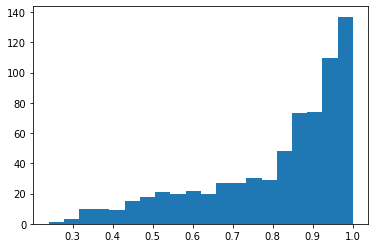

In [194]:
plt.hist(p_out_max, bins=20);
print('Percentage superior to threshlold: ', str(np.sum(p_out_max>0.95) / p_out_max.shape[0]))